# Debugging UQ-VAE loss

In [1]:
from dataclasses import dataclass
#from trainuqvae import train_uqvae
import numpy as np
from tqdm import tqdm
from utils.quality import FoM
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from utils.SLcheckpoint import load_ckp, save_ckp

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

from uqvae import NNmodel
from utils.genmatrices import genpriordist, genA, gendiagLe

In [2]:
@dataclass
class TrainingConfig:
    
    train = True
    predict = False
    numtest = 300
    
    # UQ-VAE parameters
    image_size = 128  # the image size and shape
    lamba = 0.5 # sacling parameters
    l = 0.5e-3 # [m] characteristic length
    s0 = 0.25 # prior standard deviation
    eta0 = 0.5 # prior expected value
    etae = 0 # noise mean value
    semin = 1e-3 # min value of the noise standard deviation
    semax = 5e-3 # max value of the noise standard deviation
    
    # Training parameters    
    train_batch_size = 20
    num_epochs = 200
    learning_rate = 9e-4
    val_percent = 0.2
    
    # OAT setup parameters
    Ns = 36         # number of detectors
    Nt = 1024       # number of time samples
    dx = 115e-6     # pixel size  in the x direction [m] 
    nx = 128        # number of pixels in the x direction for a 2-D image region
    Rs = 44e-3     # radius of the circunference where the detectors are placed [m]
    arco = 360      # arc of the circunferencewhere the detectors are placed
    vs = 1490       # speed of sound [m/s]
    to = 21.5e-6    # initial time [s].
    T = 25e-6       # durantion of the time window [s].
    tf = to + T     # final time [s] 
    
    # 
    cache_dir = './data/' 
    traindate = '24mar24'
    
    datadate = 't24mar24F'
    
    continuetrain = False
    plotresults = False 
    
    ckp_last='uqvae' + traindate + '.pth' # name of the file of the saved weights of the trained net
    ckp_best='uqvae_best' + traindate + '.pth'
    
    logfilename = 'TrainingLog_UQVAE' + traindate + '.log' 

In [3]:
def gettraindata(cache_dir,datadate):
    
    print('Obtaining data for training...')
    
    X = np.load(cache_dir + 'Xdas' + datadate + '.npy')
    Y = np.load(cache_dir + 'Y' + datadate + '.npy') 
    Z = np.load(cache_dir + 'ES' + datadate + '.npy') 
    
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    Z = Z.astype(np.float32)

    print('done')
    
    return X,Y,Z

In [4]:
# Training hyperparameters
config = TrainingConfig()

In [5]:
# Train parameters    
batch_size = config.train_batch_size
epochs = config.num_epochs
lr = config.learning_rate
ckp_last = config.ckp_last
ckp_best = config.ckp_best
cache_dir = config.cache_dir
datadate = config.datadate
logfilename = config.logfilename
continuetrain = config.continuetrain
plotresults = config.plotresults

In [6]:
# Set device
device = ""
    
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device to be used: {device}")

Device to be used: cuda


In [7]:
# Create the network    
net = NNmodel().to(device=device)
#print(net)
    
# Number of net parameters
NoP = sum(p.numel() for p in net.parameters())
print(f"The number of parameters of the network to be trained is: {NoP}")  

The number of parameters of the network to be trained is: 196269958


In [8]:
# Get data
print('Loading data...')
X,Y,Z = gettraindata(cache_dir,datadate)
print('Shuffling data...')
indpat = np.arange(0, Y.shape[0], dtype=int)  
ida = np.random.permutation(indpat)
X = X[ida, :, :]
Y = Y[ida, :, :]
Z = Z[ida, :, :]
x = torch.as_tensor(X[0:batch_size,:,:]).type(torch.float32).to(device=device) 
y = torch.as_tensor(Y[0:batch_size,:,:]).type(torch.float32).to(device=device) 
z = torch.as_tensor(Z[0:batch_size,:,:]).type(torch.float32).to(device=device)

Loading data...
Obtaining data for training...
done
Shuffling data...


(<matplotlib.image.AxesImage at 0x7f7a421a3c40>,
 <matplotlib.colorbar.Colorbar at 0x7f7a420ff310>)

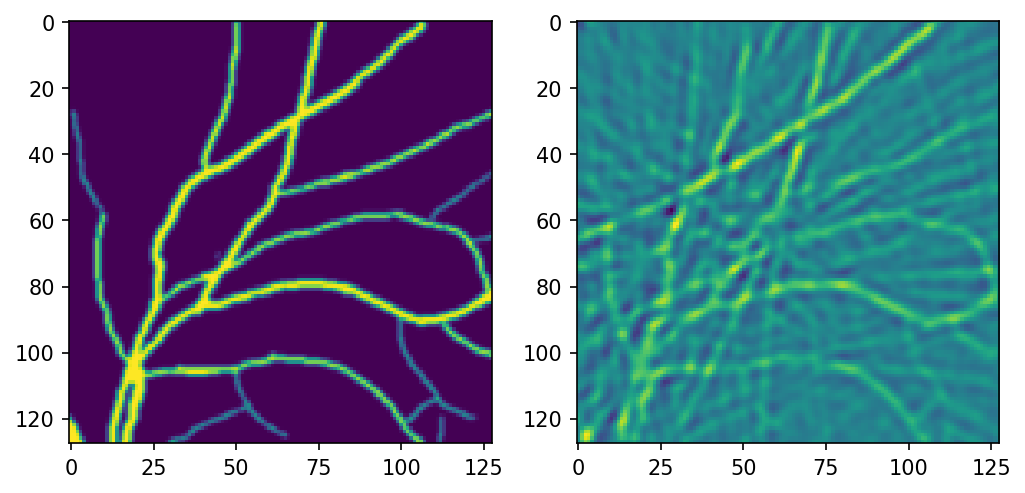

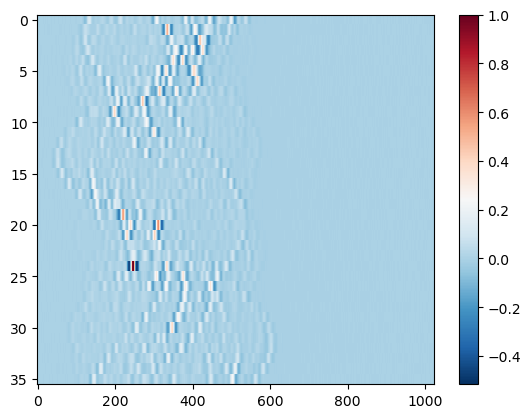

In [9]:
img = 2
fig, axs = plt.subplots(1,2,figsize=(8,8),dpi=150)
fig0 = axs[0].imshow(Y[img,:,:])
fig1 = axs[1].imshow(X[img,:,:])
#plt.colorbar(fig0)
plt.figure(),
plt.imshow(Z[img,:,:],cmap="RdBu_r",interpolation="nearest",aspect="auto"),plt.colorbar()

In [10]:
# Parameters and matrices of the UQVAE loss model
lamba = config.lamba  # UQ-VAE scaling parameter
etae = config.etae # noise mean value
eta0 = config.eta0 # prior mean value
dimS = (batch_size,1,config.Ns,config.Nt) # Sinogram shape
dimI = (batch_size,1,config.nx,config.nx) # image shape

In [11]:
# Covariance of the Gaussian Ornstein-Uhlenbeck distribution used as prior
start = time.perf_counter()
Gp0 = genpriordist(config)         
Gp0 = torch.as_tensor(Gp0).type(torch.float32).to(device=device)
end = time.perf_counter()
print('Elapsed time (minutes): ',(end - start)/60)

Elapsed time (minutes):  0.04877712316811085


In [12]:
start = time.perf_counter()
print('Creating Forward Model Matrix...')
#Ao =  np.ones((config.Nt*config.Ns,config.nx**2),dtype=np.float32)
Ao = genA(config) # Forward model matrix
Ao = Ao.todense()
print('done')
Ao = torch.as_tensor(Ao).type(torch.float32).to(device=device) 
end = time.perf_counter()
print('Elapsed time (minutes): ',(end - start)/60)

Creating Forward Model Matrix...
Creating SIR Matrix...
with shot noise effect reduction...
with angle sensitivity...


100%|██████████| 36864/36864 [00:32<00:00, 1128.01it/s]


Creating PA Matrix...
Applying Time Derivative Operator...
Applying detector impulse response...
Normalization...
done
Elapsed time (minutes):  1.5384087583632209


In [13]:
start = time.perf_counter()
print('Creating diagLe...')
diagLe =  gendiagLe(config.Ns*config.Nt,config.semin,config.semax)
print('done')
diagLe = diagLe.to(device=device) 
end = time.perf_counter()
print('Elapsed time (minutes): ',(end - start)/60)

Creating diagLe...
done
Elapsed time (minutes):  3.098993329331279e-05


## Get a first network output

In [14]:
start = time.perf_counter()
m, logs2 = net(x)
end = time.perf_counter()
print('Elapsed time (minutes): ',(end - start)/60)

Elapsed time (minutes):  0.022601369601519157


In [15]:
print(m.shape)
print(logs2.shape)

torch.Size([20, 128, 128])
torch.Size([20, 128, 128])


## Train loss

In [16]:
from utils.genmatrices import getdiagGs

In [17]:
B = y.shape[0]

$\Gamma_{po|pt}$

In [18]:
diagGs = getdiagGs(logs2,device)
print(diagGs.shape)

torch.Size([20, 16384])


$L_{po|pt}$

In [19]:
#Ls2p = torch.linalg.cholesky(Gs) # [B,nx**2,nx**2]
diagLs2 = torch.sqrt(diagGs) # [B,nx**2]
print(diagLs2.shape)

torch.Size([20, 16384])


$\log(\det(\Gamma_{po|pt})$

In [20]:
#term11 = torch.log(torch.linalg.det(Gs)) # [B,]
#term11 = torch.sum(torch.log(torch.diagonal(Gs, dim1=-2, dim2=-1))) # [B,] ---> caso matriz Gs diagonal
term11 = torch.sum(torch.log(diagGs),1) # [B,]
print(term11)

tensor([6680.4248, 5288.4868, 5724.0776, 6494.6025, 6226.9155, 4613.4902,
        6962.5415, 5995.1738, 6309.3496, 6713.8057, 5881.8252, 5095.5244,
        5728.8540, 6600.5830, 5273.8457, 7273.5195, 5636.4785, 7519.0269,
        5584.6016, 6186.8931], device='cuda:0', grad_fn=<SumBackward1>)


$\text{normL2}\left[ L_{po|pt} \left(\eta_{po|pt} - p_0 \right) \right]$

In [21]:
mmy = torch.flatten(m-y,start_dim=1) # [B,nx**2,]
#term12 = torch.sum(torch.square(torch.einsum('bi,bi->bi',diagLs2,mmy)),1) # [B,]
term12 = torch.sum(torch.square(torch.mul(diagLs2,mmy)),1) # [B,]
print(term12)

tensor([ 59240.8594,  28735.4082,  35194.2812,  88956.7891,  48087.1953,
        108501.5703,  26042.6289, 166792.2812,  45544.7812,  37474.7852,
         33987.3359,  25488.9219,  57333.8828,  70165.2578,  18473.4414,
        145846.2969,  29501.9746, 120413.1641,  39509.8203,  37352.5938],
       device='cuda:0', grad_fn=<SumBackward1>)


In [22]:
print(torch.sum(torch.square(torch.einsum('bi,bi->bi',diagLs2,mmy)),1))

tensor([ 59240.8594,  28735.4082,  35194.2812,  88956.7891,  48087.1953,
        108501.5703,  26042.6289, 166792.2812,  45544.7812,  37474.7852,
         33987.3359,  25488.9219,  57333.8828,  70165.2578,  18473.4414,
        145846.2969,  29501.9746, 120413.1641,  39509.8203,  37352.5938],
       device='cuda:0', grad_fn=<SumBackward1>)


$\frac{1-\lambda}{\lambda}\left[ \log(\det(\Gamma_{po|pt}) + \text{normL2}\left[ L_{po|pt} \left(\eta_{po|pt} - p_0 \right) \right] \right]$

In [23]:
term1 = ((1-lamba)/lamba) * (term11 + term12) # [B,]
print(term1)

tensor([ 65921.2812,  34023.8945,  40918.3594,  95451.3906,  54314.1094,
        113115.0625,  33005.1719, 172787.4531,  51854.1328,  44188.5898,
         39869.1602,  30584.4453,  63062.7383,  76765.8438,  23747.2871,
        153119.8125,  35138.4531, 127932.1875,  45094.4219,  43539.4883],
       device='cuda:0', grad_fn=<MulBackward0>)


$\epsilon \sim N(0,I_d)$

In [24]:
eps = torch.normal(0,torch.eye(dimI[2])) # [nx,nx]
#eps = eps.repeat(B,1,1) # [B,nx,nx]
eps = eps.to(device=device)
print(eps.shape)

torch.Size([128, 128])


$\tilde{p_0} = \eta_{po|pt} + L_{po|pt}^T \epsilon$

In [25]:
p0m = torch.flatten(m,start_dim=1) + torch.einsum('bi,i->bi', diagLs2,torch.flatten(eps)) # [B,nx**2]
print(p0m.shape)

torch.Size([20, 16384])


$K \, \tilde{p_0}$

In [26]:
#Sm = applyForwMat(p0m, Ao, dimS, dimI) # [B,Ns,Nt]
#Sm = torch.matmul(Ao,p0m.T).T # ((Ns*Nt,nx*nx) @ (nx*nx,B)).T = (B,Ns*Nt)
Sm = torch.einsum('ij,bj ->bi',Ao,p0m) # (B,Ns*Nt)
maxSm = Sm.max(dim=-1,keepdim=True)[0]
Smn = Sm/maxSm
print(Smn.shape)

torch.Size([20, 36864])


$\text{normL2}\left[ L_{e} \left(p_t  - K \, \tilde{p_0} - \eta_e \right) \right]$

In [27]:
SS = torch.flatten(z,start_dim=1)-Smn-etae # (B,Ns*Nt)
SSe = torch.einsum('i,bi->bi', diagLe, SS)
term2 = torch.sum(torch.square(SS),1) # [B,]
print(term2)

tensor([376.1864, 387.2843,  75.7512, 193.8190, 480.9952, 100.8343, 588.0305,
        189.9484, 612.4885, 583.3666, 679.8016, 328.5624, 427.0309, 169.1951,
        409.0781, 422.6024, 214.3401, 465.8221, 134.3621, 527.1652],
       device='cuda:0', grad_fn=<SumBackward1>)


$\text{tr} \left(\Gamma_{po}^{-1} \Gamma_{po|pt} \right)$

In [28]:
iGp0 = torch.linalg.inv(Gp0) # [N,N] ----> Se calcula una vez!!!
term31 = torch.sum(torch.einsum('ij,bj->bi', iGp0,diagGs),1) # [B,]
print(term31)

# Otra forma de hacerlo
#sumatoria(multil(elementos diagnal de cada una)

tensor([ 6563.1074,  5396.3672,  5703.0586,  6909.2812,  7017.1758,  5708.7930,
         6255.6562,  8499.5000,  6226.3633,  6530.5625,  5992.9688,  5044.1445,
         6501.5840, 10064.5781,  5606.7715,  7783.5625,  6042.4453,  6126.1797,
         6699.8242,  5780.5625], device='cuda:0', grad_fn=<SumBackward1>)


$\text{normL2} \left[ L_{po} \left(\eta_{po|pt} - \eta_{po} \right) \right]$

In [29]:
Lp0 = torch.linalg.cholesky(iGp0) 
print(Lp0.shape)

torch.Size([16384, 16384])


In [30]:
mF = torch.flatten(m,start_dim=1)
term32 = torch.sum(torch.einsum('ij,bj->bi', Lp0,mF-eta0),1) # [B,]
print(term32)

tensor([ -590.7017, -1106.9154,  -566.8257,  -554.0543, -1193.1990, -1220.5193,
         -613.5221, -1007.8669,  -782.1757,  -830.0229,  -979.6731, -1206.5969,
        -1205.1453, -1150.3093, -1383.6963,  -192.6510,  -936.7562,  -100.5640,
        -1335.2263, -1072.3435], device='cuda:0', grad_fn=<SumBackward1>)


$\log \left( \frac{\det(\Gamma_{po})}{\det(\Gamma_{po|pt})} \right)$

In [31]:
logdetGp0 = torch.log(torch.linalg.det(Gp0) + 2e-45) #  ----> el det da cero!!!!!!
term33 = logdetGp0 - term11 # [B,]  
print(term33)

tensor([-6783.7036, -5391.7656, -5827.3564, -6597.8813, -6330.1943, -4716.7690,
        -7065.8203, -6098.4526, -6412.6284, -6817.0845, -5985.1040, -5198.8032,
        -5832.1328, -6703.8618, -5377.1245, -7376.7983, -5739.7573, -7622.3057,
        -5687.8804, -6290.1719], device='cuda:0', grad_fn=<SubBackward0>)


$\text{tr} \left(\Gamma_{po}^{-1} \Gamma_{po|pt} \right) + \text{normL2} \left[ L_{po} \left(\eta_{po|pt} - \eta_{po} \right) \right] + \log \left( \frac{\det(\Gamma_{po})}{\det(\Gamma_{po|pt})} \right)$

In [32]:
term3 = term31 + term32 + term33 # [B,]
print(term3)

tensor([ -811.2979, -1102.3140,  -691.1235,  -242.6543,  -506.2178,  -228.4956,
        -1423.6860,  1393.1802,  -968.4409, -1116.5449,  -971.8081, -1361.2556,
         -535.6943,  2210.4067, -1154.0493,   214.1133,  -634.0684, -1596.6899,
         -323.2827, -1581.9531], device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
loss = (1/B) * torch.sum(term1 + term2 + term3) # [1]
print(loss)

tensor(67018.4062, device='cuda:0', grad_fn=<MulBackward0>)
